# prfpy for nCSF fitting. Example notebook

In [1]:
# Assuming you have already installed prfpy_csenf

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')
import os
opj = os.path.join
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#
from prfpy_csenf.model import CSenFModel
from prfpy_csenf.stimulus import CSenFStimulus
from prfpy_csenf.fit import CSenFFitter
from prfpy_csenf.rf import * 
from prfpy_csenf.csenf_plot_functions import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load stimulus settings 

In [2]:
# Make some example experiment parameters.
# These are the ones used in (*citation*)
# 6 SF levels
SF_levels = [ 0.5,  1.,   3.,   6.,  12.,  18. ] 
# 14 contrasts levels. Log spaced between 0.25 and 80
# [0.25, 0.39, 0.607, 0.946, 1.475, 2.299, 3.582, 5.583, 8.701, 13.56, 21.134, 32.937, 51.332, 80.]
contrast_levels = np.logspace(np.log10(0.25), np.log10(80), 14)

# stimulus sequence
# blank -> random SF descending contrast -> random SF ascending contrast -> blank ... repeat
# i.e., 
# SF_order = [0, 3, 18, 0, 1, 6, 0, 0.5, 12, 0, 6, 1, 0, 12, 3, 0,  18, 0.5, 0]
# -> also include blanks
# blank_length = 10 

# We also miss out some contrast levels for some frequencies, to sample parameter space more efficiently...
# See paper for details
# Load them in here
# Sequence of SFs and contrast levels (214 steps)
sfs_seq = np.load('eg_sfs_seq.npy')
con_seq = np.load('eg_con_seq.npy')


#### Create a stimulus object

In [3]:
# Following the prfpy structure, we can create a stimulus object
# This will put all the stimuli information in one place
# requires: 
# > the sequence of SFs presented (i.e., 1 per TR, blanks represented with 0) 
# > the sequence of contrasts presented ("")
# > TR

csenf_stim = CSenFStimulus(
    SF_seq  = sfs_seq, # np array, 1D 
    CON_seq = con_seq, # np array, 1D 
    TR      = 1.5,
    discrete_levels=True, # If discrete levels of SF and contrast. Default is true
    )


Number of timepoints: 214
Number of unique SF levels: 6, [ 0.5  1.   3.   6.  12.  18. ]
Number of unique CON levels: 14, [ 0.25   0.39   0.607  0.946  1.475  2.299  3.582  5.583  8.701 13.56
 21.134 32.937 51.332 80.   ]


In [4]:
# Now we can make a prfpy_model object. 
csenf_model = CSenFModel(
    stimulus = csenf_stim,    
    hrf=[1,1,0],
    edge_type='CRF',
)


#### Create an example model
Now we can create an example instance of a model. We will use the parameters from chung & legge

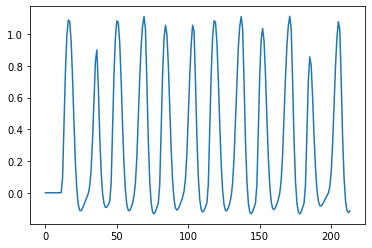

In [5]:
# Now we can some example nCSF models
# For the first entry CSF parameters are taken from the Chung & Legge paper. 
# Everything else is picked pretty randomly
# To really get to grips on how changing model parameters works try out the 'csenf_widget' notebook

eg_params = {
    #                                
    'width_r'           : np.array([   1.28,   1.50,   1.00,   1.00,]), # [CSF parameters]    
    'SFp'               : np.array([   2.50,   1.00,   4.00,   2.00,]), # 
    'CSp'               : np.array([ 166.00, 100.00,  80.00,  40.00,]), # 
    'width_l'           : np.array([   0.68,   0.68,   0.68,   0.68,]), # 
    'crf_exp'           : np.array([   1.50,   1.50,   2.50,   3.00,]), # [CRF parameter]
    'amp_1'             : np.array([   1.00,   1.00,   1.00,   1.00,]), # [fMRI parameters]
    'bold_baseline'     : np.array([   0.00,   0.00,   0.00,   0.00,]), # 
    'hrf_1'             : np.array([   1.00,   1.00,   1.00,   1.00,]), # 
    'hrf_2'             : np.array([   0.00,   0.00,   0.00,   0.00,]), # 
    }
# Now we can use these with our stimulus info to generate a time series!
eg_ts = csenf_model.return_prediction(
    width_r     = eg_params['width_r'],
    SFp         = eg_params['SFp'],
    CSp         = eg_params['CSp'],
    width_l     = eg_params['width_l'],                          
    crf_exp     = eg_params['crf_exp'],
    beta        = eg_params['amp_1'],
    baseline    = eg_params['bold_baseline'],
    hrf_1       = eg_params['hrf_1'],
    hrf_2       = eg_params['hrf_2'],
)
plt.plot(eg_ts[3,:])


#### Making everything a bit prettier
I've put together some functions to make it easier to visualize and plot your nCSF models

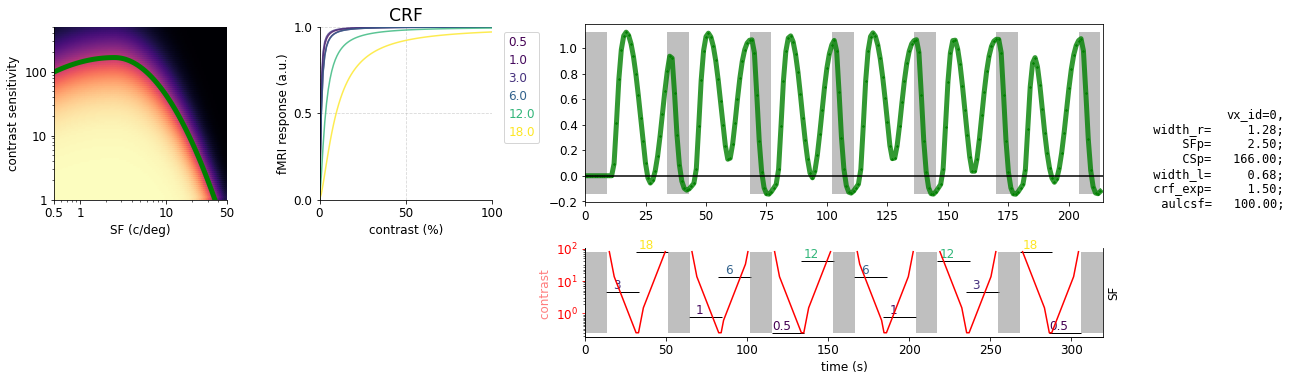

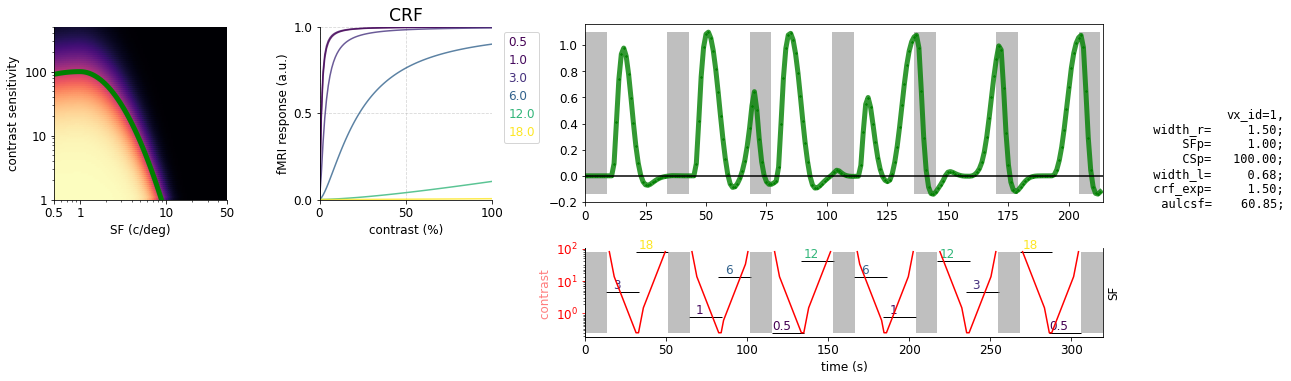

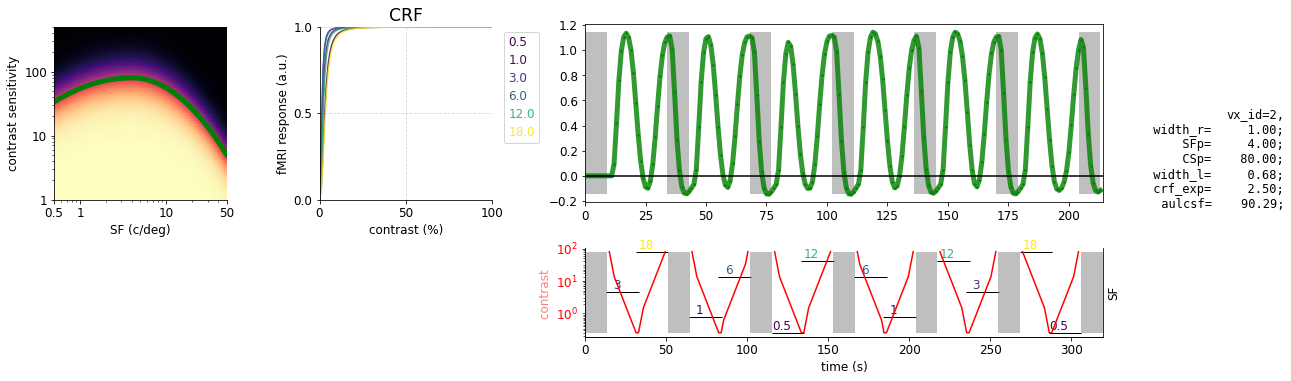

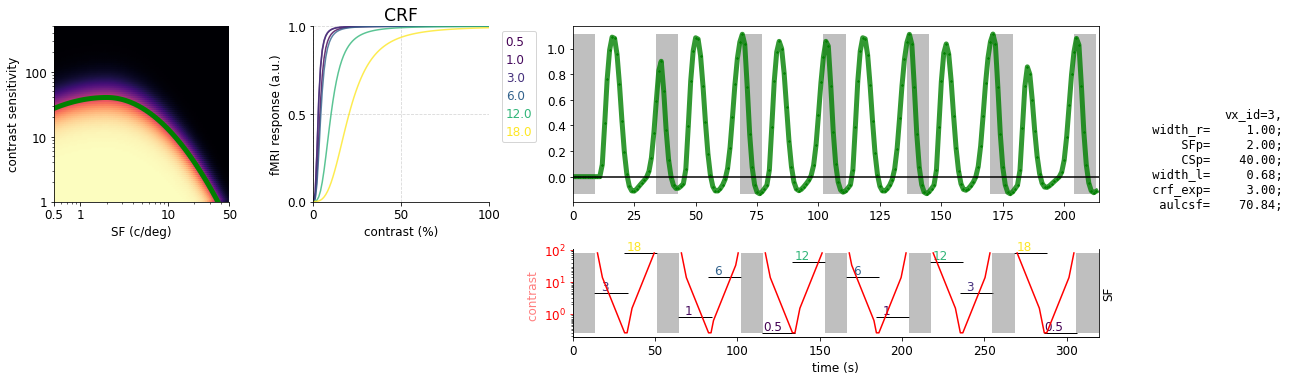

In [6]:
from prfpy_csenf.csenf_plot_functions import *

csenf_plot = CSenFPlotter(
    eg_params,
    prfpy_model=csenf_model, # Include the model so we can generate predictions
    )
# Lets look at the first example model
for i in range(4):
    csenf_plot.csf_ts_plot(idx=i)


From left to right top to bottom:

[1] CSF curve (spatial freq on x axis, log spaced). The green line shows the shape of the traditional "CSF" curve. The colormap below includes the slope component. Showing how the activity changes smoothly from lower to higher contrasts. The little red dots indicate the data points we sample (i.e. what is presented to the subject)

[2] CRF curves. As we go from low to high contrast, the responses change. The slope of these responses is determined by the parameter "crf_exp" aka the "crf_slope". The "C50" or semisaturation point (where the response=50) is determined by our CSF function (see [1]). So that means the crf curve will differ for different SFs. We show several SFs here.

[3] The timeseries of the model. The response of the model at each time point is determined by looking up the nCSF values at that contrast + SF level, and then convolving with the HRF

[4] Stimulus info: gray bars = blanks (isoluminant gray); contrast levels in red, SF levels in black

# Demonstration of fitting procedure

To show you how the fitting works. First lets make some fake data

We'll use the models with the example parameters above; add some gaussian noise and then fit that

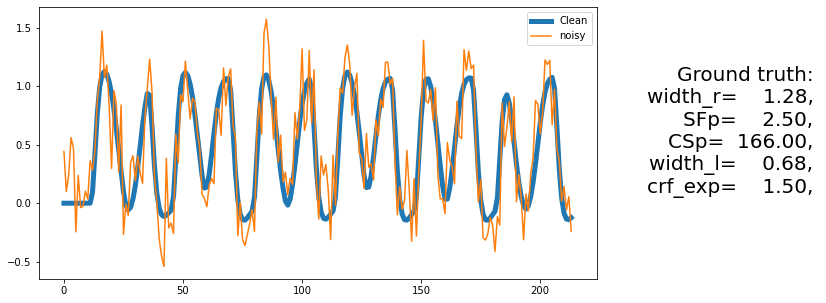

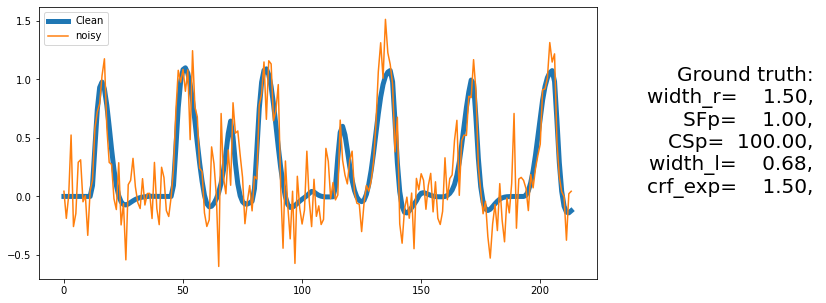

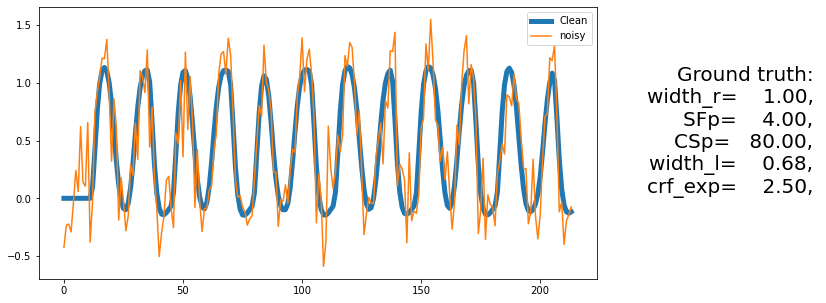

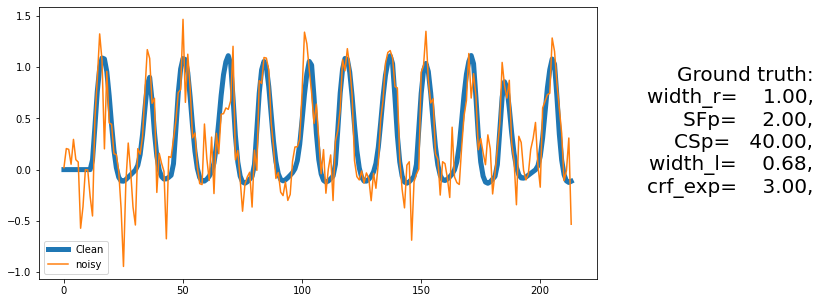

In [7]:
np.random.seed(0)
num_noise_reps = 100 # Per 
noise_value = .25


n_timepoints = eg_ts.shape[-1]          # number of timepoints in simulated timecourse
noisy_sim_tc = []                       # list of all the time series
csf_model_index = []                    # list to store index of parameter set for each timecourse
noise_index = []

for i_eg in range(eg_params['width_r'].size): # Loop through the example models
    g_noise = np.random.normal(0, noise_value, (num_noise_reps, n_timepoints))            
    noisy_sim_tc.append(eg_ts[i_eg,:] + g_noise)        
    csf_model_index.append([i_eg] * num_noise_reps)

noisy_sim_tc = np.vstack(noisy_sim_tc)
csf_model_index = np.hstack(csf_model_index)

# Lets see what the noisy time series look like...
for i_eg in [0,1,2,3]:
    # Plot the clean timecourse
    plt.figure(figsize=(10,5))
    plt.plot(eg_ts[i_eg,:], lw=5, label='Clean')
    # Now plot the noisy ts
    noisy_id = np.where(csf_model_index==i_eg)[0][0]        
    plt.plot(
        noisy_sim_tc[noisy_id,:], 
        label='noisy')
    
    plt.legend()        

    gt_txt = 'Ground truth: \n' + \
        f'width_r={eg_params["width_r"][i_eg]:>8.2f}, \n' + \
        f'SFp={eg_params["SFp"][i_eg]:>8.2f}, \n' + \
        f'CSp={eg_params["CSp"][i_eg]:>8.2f}, \n' + \
        f'width_l={eg_params["width_l"][i_eg]:>8.2f}, \n' + \
        f'crf_exp={eg_params["crf_exp"][i_eg]:>8.2f}, \n'
    # Add text to outside right of plot
    # Use monospaced font
    plt.text(
        1.4, 0.5, gt_txt, transform=plt.gca().transAxes, 
        fontsize=20, va='center', ha='right',
        # family='monospace',
        )

#### Setting fitting parameters and running the fit
Before we start fitting we need to set our parameters for the fitting process

In [8]:
# [1] Bounds - what are the bounds on the parameters we are fitting. Make sure model remains reasonable
# We find the following to be suitable
# -> to get an intuition of how the parameters vary try the csenf_widget notebook
bounds = {
    'width_r'       : [0,1.5],          
    'SFp'           : [0, 6],
    'CSp'           : [0, 200] ,
    'width_l'       : [0.68, 0.68],     # we fix width_l in our model
    'crf_exp'       : [0, 10] ,
    'amp_1'         : [0, 1000],       # Amplitude of TC
    'bold_baseline' : [-5,5] ,         # bold baseline (i.e., where is zero)
    'hrf_1'         : [1, 1],          # hrf derivative 
    'hrf_2'         : [0,0],           # hrf dispersion
}
# Here we fix the hrf derivative and dispersion

# [2] Setup grids:
# -> we create a grid of possible models across parameter space
# -> find the best model for a time series and put that into the next stage (the iterative fit)
grid_nr = 5 # number of steps in grid
width_r_grid        = np.linspace(bounds['width_r'][0], bounds['width_r'][1], grid_nr)     
SFp_grid            = np.linspace(bounds['SFp'][0], bounds['SFp'][1], grid_nr)     
CSp_grid            = np.linspace(bounds['CSp'][0], bounds['CSp'][1], grid_nr)
width_l_grid        = np.array(bounds['width_l'][0]) # FIXED...
crf_exp_grid        = np.linspace(bounds['crf_exp'][0], bounds['crf_exp'][1], grid_nr)
hrf_1_grid = None
hrf_2_grid = None

# [3] Setup grid bounds
# -> the grid stage of the fitting, the amplitude is fit (using simple regression) 
# -> so unlike the other parameters, we need to specify the bounds
grid_bounds = [bounds['amp_1']]
# Fixed grid baseline. Do you think the bold base line should be fixed?
# -> this might be true if you have done some % signal change, based on "blank time periods"
fixed_grid_baseline=False

# [4] Create bounds list - to enter into prfpy fitting object
bounds_list = [
    (bounds['width_r']),     # width_r
    (bounds['SFp']),     # SFp
    (bounds['CSp']),    # CSp
    (bounds['width_l']),     # width_l
    (bounds['crf_exp']),     # crf_exp
    (bounds['amp_1']),   # amp_1
    (bounds['bold_baseline']),      # baseline
    (bounds['hrf_1']),      # baseline
    (bounds['hrf_2']),      # baseline
]


A quick note on "constraints" 

*Note 1* When fitting with prfpy it is possible to specify constraints. These are like bounds, but where bounds are determined by another parameter. This could be useful if you have reason to believe that a certain parameter covaries with another in a "lawful" way. 

*Note 2* "Under the hood" prfpy uses scipy.optimize algorithms to optimize the solution in the iterative stage of the fitter. You can look these up in the scipy documentation. Importantly if you specify some constraints it will use the "trust-constraint" (TC) algorithm. If you do not it will use the l-bgfs algorithm. 

l-bgfs is much faster that TC, but TC will explore the parameter space more thoroughly. For this reason sometimes it is useful to specify the TC fitter, even if you don't have any constraints in mind. If you want to do this you can make constraints=[] (i.e., an empty list) 

In [9]:
# -> Constraints determines which scipy fitter is used
csf_constraints = None   # None -> bgfs, [] -> TC


Other fitting parameters 

In [10]:
# number of jobs -> how parallelized do you want it
n_jobs = 10
# xtol, ftol: scipy optimize parameters, how quickly do you want the optimizer to stop looking for a solution
xtol = 0.0001
ftol = 0.0001

# rsq threshold. Throw away all fits which have a variance explained lower than:
rsq_threshold = 0.1 


Make the prfpy_fitter object

In [11]:
csenf_fitter = CSenFFitter(
    data    = noisy_sim_tc,
    model   = csenf_model,
    n_jobs=n_jobs,
)

Start the grid fit

In [12]:
# Time how long the fitting takes
start_time = time.time()
csenf_fitter.grid_fit(
    width_r_grid    = width_r_grid,
    SFp_grid        = SFp_grid,
    CSp_grid        = CSp_grid,
    width_l_grid    = width_l_grid,
    crf_exp_grid    = crf_exp_grid,
    hrf_1_grid      = hrf_1_grid,
    hrf_2_grid      = hrf_2_grid,
    verbose         = True, # Print information...
    fixed_grid_baseline = fixed_grid_baseline,
    grid_bounds = grid_bounds, 
    n_batches = n_jobs,
)
# Print how long it took in minutes and seconds
grid_time = (time.time() - start_time)/60
print(f'Grid fitting took {grid_time} minutes')
m_rsq = csenf_fitter.gridsearch_params[:,-1].mean()
rsq_gt_pt1 = np.sum(csenf_fitter.gridsearch_params[:,-1]>0.1)
m_rsq_th = csenf_fitter.gridsearch_params[csenf_fitter.gridsearch_params[:,-1]>0.1,-1].mean()
print(f'Grid stage, of voxels fit: Mean r^2 = {m_rsq}')
print(f'Grid stage, nr voxels with rsq>0.1={rsq_gt_pt1}')
print(f'Grid stage, mean rsq for voxels with rsq>0.1={m_rsq_th}')


Each batch contains approx. 40 voxels.


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/fit.py:2027: RuntimeWarning: invalid value encountered in true_divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/fit.py:2044: RuntimeWarning: invalid value encountered in less
  resid[slopes<grid_bounds[0][0]] = +np.inf
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/fit.py:2045: RuntimeWarning: invalid value encountered in greater
  resid[slopes>grid_bounds[0][1]] = +np.inf
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/fit.py:2027: RuntimeWarning: invalid value encountered in true_divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/fit.py:2044: RuntimeWarning: i

Grid fitting took 0.05175959666570028 minutes
Grid stage, of voxels fit: Mean r^2 = 0.724684903472662
Grid stage, nr voxels with rsq>0.1=400
Grid stage, mean rsq for voxels with rsq>0.1=0.724684903472662


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/fit.py:2027: RuntimeWarning: invalid value encountered in true_divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/fit.py:2027: RuntimeWarning: invalid value encountered in true_divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/fit.py:2044: RuntimeWarning: invalid value encountered in less
  resid[slopes<grid_bounds[0][0]] = +np.inf
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/fit.py:2044: RuntimeWarning: invalid value encountered in less
  resid[slopes<grid_bounds[0][0]] = +np.inf
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/fit.py:2045: RuntimeWarning: invalid value encountered in greater
  resid[slopes>grid_bounds[0][1]] = +np.inf


Start the iterative fit. Using the grid fit stage as a starting point

In [13]:
start_time = time.time()
# Start iterative fit
print('Starting iterative fit')
csenf_fitter.iterative_fit(
    rsq_threshold = rsq_threshold,
    verbose = False,
    bounds = bounds_list,
    constraints = csf_constraints,
    xtol=xtol,   
    ftol=ftol,           
    )
# Print how long it took in minutes and seconds
iter_time = (time.time() - start_time)/60
print(f'Iterative fitting took {iter_time} minutes')
print(f'Total time = {iter_time + grid_time} minutes')
m_rsq = csenf_fitter.iterative_search_params[:,-1].mean()
rsq_gt_pt1 = np.sum(csenf_fitter.iterative_search_params[:,-1]>0.1)
m_rsq_th = csenf_fitter.iterative_search_params[csenf_fitter.iterative_search_params[:,-1]>0.1,-1].mean()
print(f'Iterative stage, of voxels fit: Mean r^2 = {m_rsq}')
print(f'Iterative stage, nr voxels with rsq>0.1={rsq_gt_pt1}')
print(f'Iterative stage, mean rsq for voxels with rsq>0.1={m_rsq_th}')    

Starting iterative fit


/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/daghlian/.cond

Iterative fitting took 0.39331668615341187 minutes
Total time = 0.44507628281911216 minutes
Iterative stage, of voxels fit: Mean r^2 = 0.743691450687638
Iterative stage, nr voxels with rsq>0.1=400
Iterative stage, mean rsq for voxels with rsq>0.1=0.743691450687638


# Exploring fitting results

In [14]:
# First lets use our plotter to look at some of the results

csenf_plot_fit = CSenFPlotter(
    csenf_fitter.iterative_search_params,
    prfpy_model=csenf_model, # Include the model so we can generate predictions
    real_ts    = noisy_sim_tc,
    )



prf_params.shape[-1]=10
hrf=params[:,7,8], rsq=params[:,9]


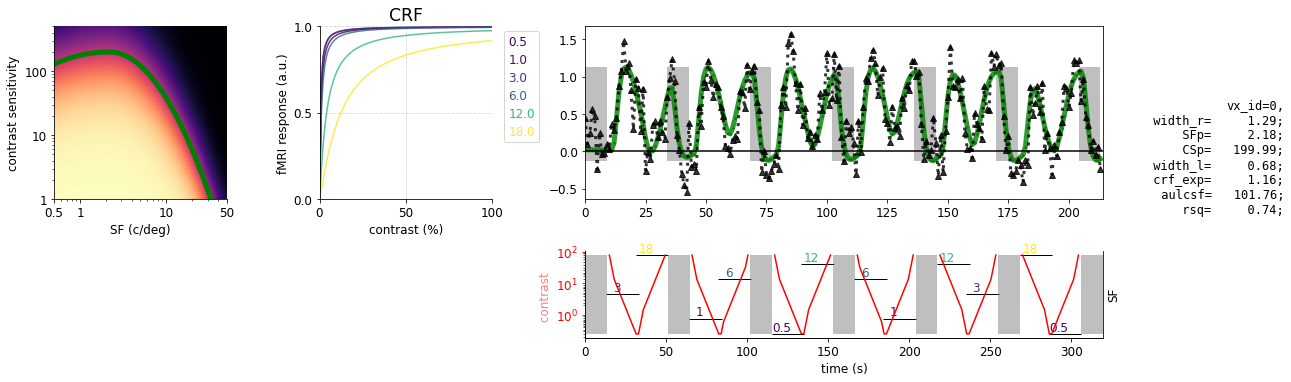

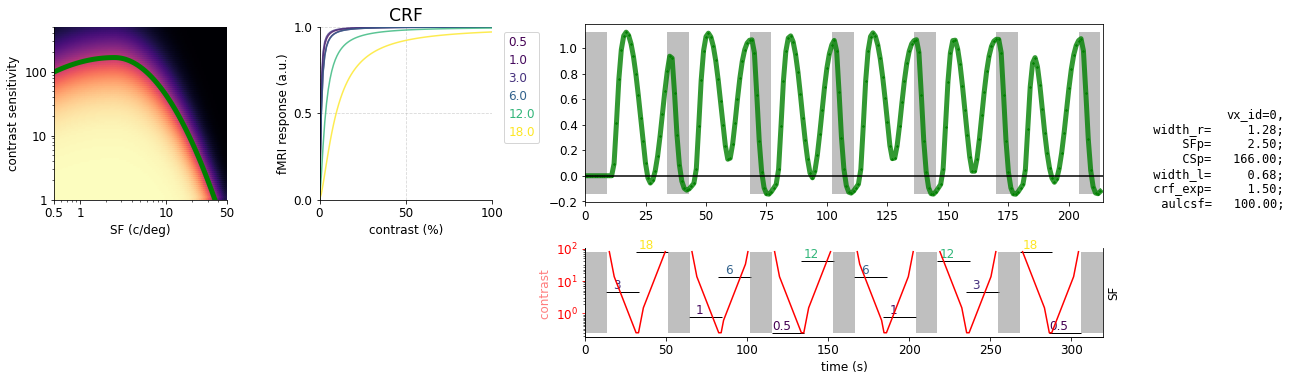

In [25]:
# Compare the fit (green) vs the dotted line black line (data) 
csenf_plot_fit.csf_ts_plot(0)

# Now lets look at the original "ground truth" model
csenf_plot.csf_ts_plot(0)

# They should be pretty similar!

For a more systematic, rigorous testing of the ability of the model to capture different levels of noise see paper section on the simulations